In [1]:
from scipy.special import expit
import os
import gzip
import pickle
import wget
import random
import numpy as np
from scipy.special import softmax
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline



In [2]:
def plotThis(x, label ):
    xnew = np.linspace(np.arange(x.shape[0]).min(),np.arange(x.shape[0]).max(),300)
    spl = make_interp_spline(np.arange(x.shape[0]),x, k=3)
    power_smooth = spl(xnew)
    xx = plt.plot(xnew,power_smooth, label = label)

def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

def load_mnist():
    if not os.path.exists(os.path.join(os.curdir, 'data')):
        os.mkdir(os.path.join(os.curdir, 'data'))
        wget.download('http://deeplearning.net/data/mnist/mnist.pkl.gz', out='data')

    data_file = gzip.open(os.path.join(os.curdir, 'data', 'mnist.pkl.gz'), 'rb')
    training_data, validation_data, test_data = pickle.load(data_file, encoding='latin1')
    data_file.close()

    training_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in training_data[0]]))
    training_results = np.squeeze(np.asarray([vectorized_result(y) for y in training_data[1]]))

    validation_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in validation_data[0]]))
    validation_results = np.asarray(validation_data[1])
    
    test_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in test_data[0]]))
    test_results = np.squeeze(np.asarray(test_data[1]))
    return training_inputs, training_results, validation_inputs, validation_results, test_inputs, test_results

training_inputs, training_results, validation_inputs, validation_results, test_inputs, test_results= load_mnist()

In [3]:
np.random.seed(5)
def softmaxx(z):
        return softmax(z, axis=1)

def sigmoid(z):
    return expit(z)

def sigmoid_prime(z):
    return z*(1-z)

def ReLU(z):
    return np.maximum(z, 0)

def ReLU_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x**2

    
class NN(object):
    def __init__(self, network_units, activation_fn, lr, batch_size, initialization):
        self.network_units = network_units
        if activation_fn =="ReLU":
            self.activation_fn = ReLU
            self.activation_p = ReLU_prime
        elif activation_fn == "sigmoid":
            self.activation_fn = sigmoid
            self.activation_p = sigmoid_prime
        elif activation_fn == "tanh":
            self.activation_fn = tanh
            self.activation_p = tanh_prime
        self.parameters = {}
        self.gradients = {}
        self.initialization = initialization
        self.initialize_weights()
        self.lr = lr
        self.batch_size = batch_size
    def initialize_weights(self):
        
        for i in range(len(self.network_units)-1):
            
            self.parameters["b"+str(i)] = np.zeros((self.network_units[i+1]))
            
            if self.initialization == "glorot":
                self.parameters["w"+str(i)] = np.random.uniform( 
                                -np.sqrt(6./(self.network_units[i]+self.network_units[i+1])), 
                                np.sqrt(6./(self.network_units[i]+self.network_units[i+1])),
                                size=(self.network_units[i],self.network_units[i+1])
                                                              )
            elif self.initialization == "normal":
                self.parameters["w"+str(i)] = np.random.normal(scale=1, size=(self.network_units[i],self.network_units[i+1]))
            
            elif self.initialization == "zero":
                self.parameters["w"+str(i)] = np.zeros(shape=(self.network_units[i],self.network_units[i+1]))
    
            self.gradients["b"+str(i)] = np.zeros((self.network_units[i+1]))
            self.gradients["w"+str(i)] = np.zeros((self.network_units[i], self.network_units[i+1]))

            
    def num_parameters(self):
        pars = 0.0
        for i in range(len(self.network_units)-1):
            pars += self.network_units[i]
            pars += (self.network_units[i] * self.network_units[i+1])
        print("we have ", pars/1000000, " parameters")
    
    def forward(self, x):
        self.x = x
        self.h1 = self.activation_fn(np.dot(x, self.parameters["w0"]) + self.parameters["b0"])
        self.h2 = self.activation_fn(np.dot(self.h1, self.parameters["w1"]) + self.parameters["b1"])
        self.out = expit(np.dot(self.h2, self.parameters["w2"]) + self.parameters["b2"])
        return self.out
    
    def loss(self, y):
        self.y = y
        l = -y*np.log(self.out+1e-8)-(1-y)*np.log(1-self.out+1e-8)
        m_b_l = np.sum(l, axis=1)
        self.lossy = np.mean(m_b_l)
        return self.lossy
    
    def backward(self):
        
        dout = (-self.y/(self.out+1e-8)) + (1-self.y) * (1/(1-self.out+1e-8))
        del2 = self.out*(1-self.out)*dout
        doutdw2 = np.dot(self.h2.T, del2)/len(self.x)
        doutdb2 = np.mean(del2, axis=0)
        
        
        douth2 = np.dot(del2, self.parameters["w2"].T)
        del1 = self.activation_p(self.h2)*douth2
        doutdw1 = np.dot(self.h1.T, del1)/len(self.x)
        doutdb1 = np.mean(del1, axis=0)
        
        douth1 = np.dot(del1, self.parameters["w1"].T)
        del0 = self.activation_p(self.h1)*douth1
        doutdw0 = np.dot(self.x.T, del0)/len(self.x)
        doutdb0 = np.mean(del0, axis=0)
        
        self.gradients["w2"] = doutdw2
        self.gradients["b2"] = doutdb2
        self.gradients["w1"] = doutdw1
        self.gradients["b1"] = doutdb1
        self.gradients["w0"] = doutdw0
        self.gradients["b0"] = doutdb0
        
    def update(self):
        for ind in ["w0", "w1", "w2", "b0", "b1", "b2"]:
            self.parameters[ind] -= self.lr * self.gradients[ind]

    def train(self,training_inputs, training_results, epochs, validation_inputs, validation_targets):
        loss = np.zeros((epochs))
        accuracy = np.zeros((epochs))
        for epoch in range(epochs):
            shuffle(training_inputs, training_results, random_state=0)
            mini_batches = [training_inputs[k:k+self.batch_size] for k in range(0, training_inputs.shape[0], self.batch_size)]
            mini_batches_results = [training_results[k:k+self.batch_size] for k in range(0, training_results.shape[0], self.batch_size)]
            #print(mini_batches_results[0])
            #break
            current_loss=0
            for mini_batch_index in range(len(mini_batches)):
                self.forward(mini_batches[mini_batch_index])
                current_loss += self.loss(mini_batches_results[mini_batch_index])
                self.backward()
                self.update()
            current_loss /= len(mini_batches)
            loss[epoch] = current_loss
            print("loss ", current_loss)
            currentAccuray = self.test(validation_inputs, validation_targets)
            accuracy[epoch] = currentAccuray
        return loss, accuracy 
    def test(self, validation_inputs, validation_targets):
        results = self.forward(validation_inputs)
        labels = np.argmax(results, axis=1)
        accuracy = np.sum(labels == validation_targets)/100
        print("validation accuracy", accuracy)
        return accuracy

In [4]:
myNet = NN([784,500,500,10], "ReLU", lr=0.01, batch_size=32, initialization="glorot")
glorot_relu_loss, glorot_relu_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  1.169024070649404
validation accuracy 91.51
loss  0.5797471351744949
validation accuracy 93.44
loss  0.4639278480012451
validation accuracy 94.51
loss  0.39350342131114996
validation accuracy 95.28
loss  0.3424973662421868
validation accuracy 95.85
loss  0.3030742284051504
validation accuracy 96.23
loss  0.27149912776012747
validation accuracy 96.63
loss  0.24552161032026226
validation accuracy 96.87
loss  0.22378022889489874
validation accuracy 96.99
loss  0.2052481496417222
validation accuracy 97.2


In [5]:
myNet = NN([784,500,500,10], "ReLU", lr=0.01, batch_size=32, initialization="normal")
normal_relu_loss, normal_relu_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)


loss  22.30360089494115
validation accuracy 9.9
loss  18.43062463750096
validation accuracy 9.9
loss  18.4306246370211
validation accuracy 9.9
loss  18.430624636260713
validation accuracy 9.9
loss  18.430624634900706
validation accuracy 9.9
loss  18.43062463192537
validation accuracy 9.9
loss  18.430624622243517
validation accuracy 9.9
loss  18.43062452673685
validation accuracy 9.9
loss  18.42790479922721
validation accuracy 9.9
loss  18.427309977640338
validation accuracy 9.9


In [6]:
myNet = NN([784,500,500,10], "ReLU", lr=0.01, batch_size=32, initialization="zero")
zero_relu_loss, zero_relu_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  3.9038961822548104
validation accuracy 10.64
loss  3.263139512360626
validation accuracy 10.64
loss  3.2499328012046065
validation accuracy 10.64
loss  3.2492479667845178
validation accuracy 10.64
loss  3.2492051413143557
validation accuracy 10.64
loss  3.2492018641627025
validation accuracy 10.64
loss  3.249201468825749
validation accuracy 10.64
loss  3.2492013871150247
validation accuracy 10.64
loss  3.2492013652469045
validation accuracy 10.64
loss  3.249201359024071
validation accuracy 10.64


<IPython.core.display.Javascript object>


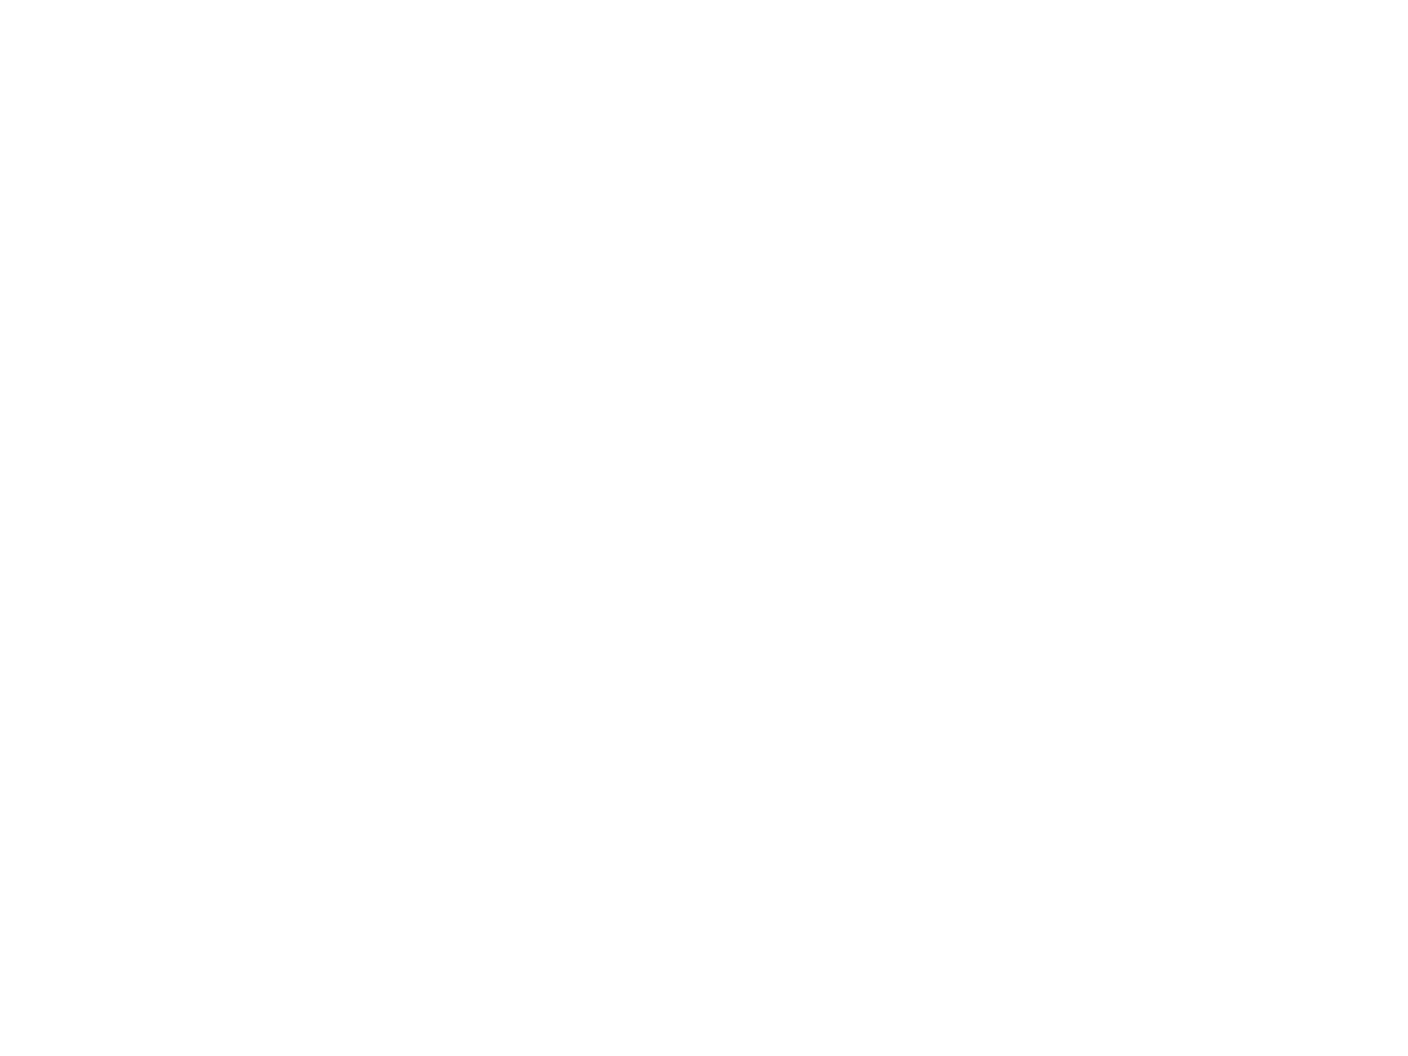

In [7]:
%matplotlib notebook
plotThis(glorot_relu_loss, "glorot relu loss")
plotThis(zero_relu_loss, "zero relu loss")
plotThis(normal_relu_loss, "normal relu loss")

plt.title("training loss")
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


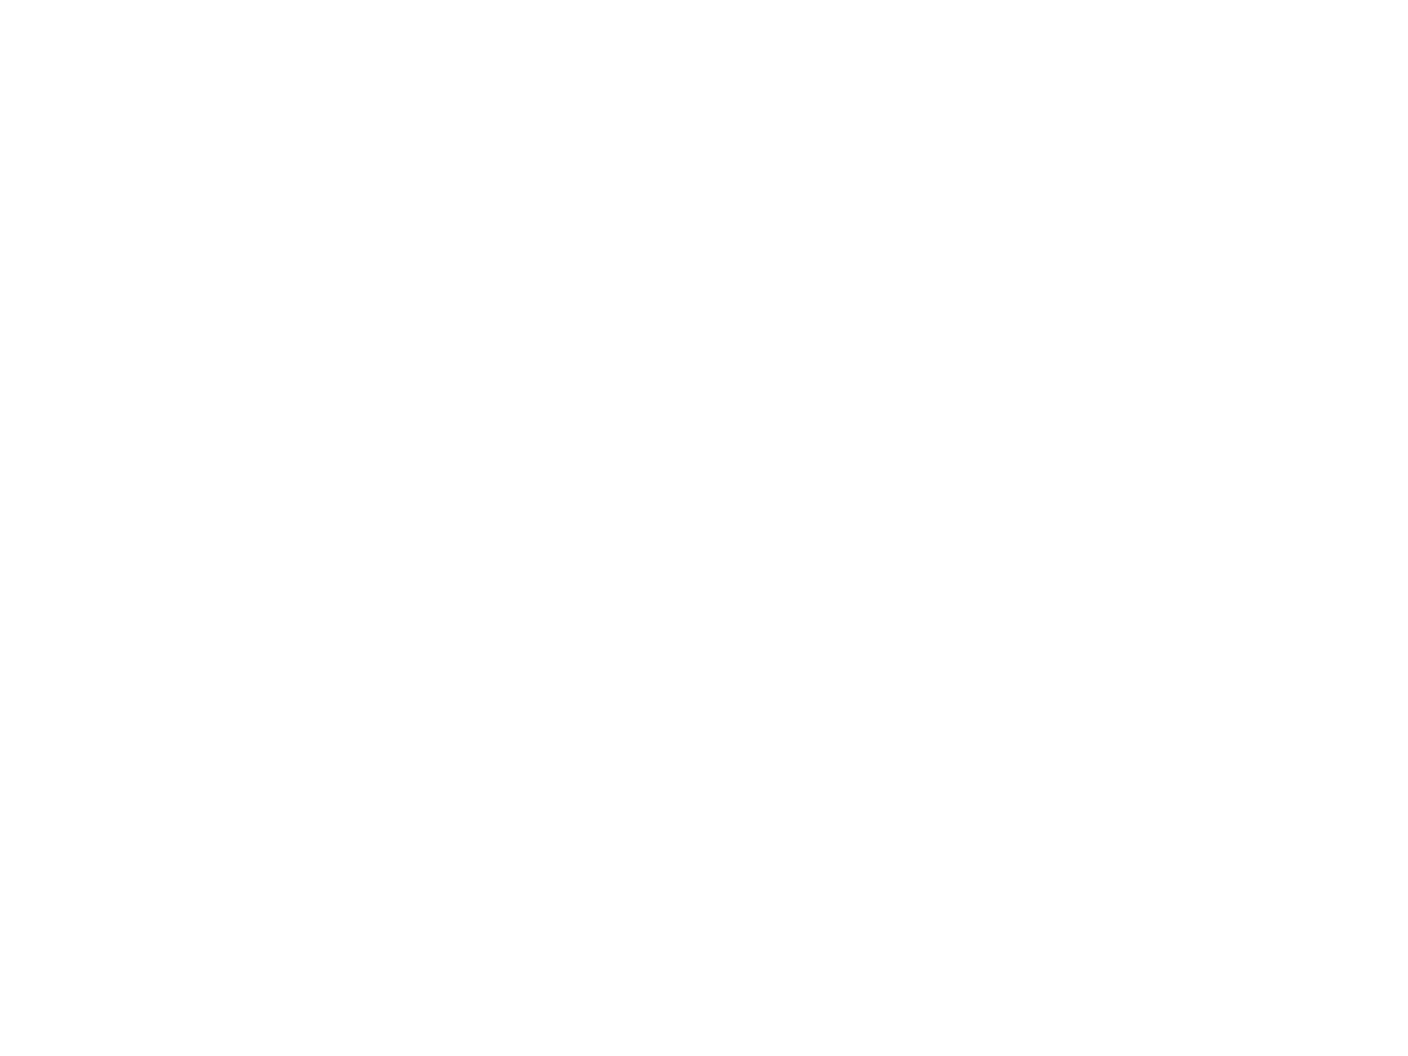

In [8]:
%matplotlib notebook
plotThis(glorot_relu_accuracy, "glorot relu accuracy")
plotThis(zero_relu_accuracy, "zero relu accuracy")
plotThis(normal_relu_accuracy, "normal relu accuracy")

plt.title("evaluation accuracy")
plt.legend()
plt.show()


In [9]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="glorot")
glorot_tanh_loss, glorot_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  1.1142485375457774
validation accuracy 90.58
loss  0.6946124545307343
validation accuracy 91.99
loss  0.6039808251588278
validation accuracy 92.78
loss  0.5390805531951847
validation accuracy 93.47
loss  0.48557205883528853
validation accuracy 94.14
loss  0.44113891097558305
validation accuracy 94.66
loss  0.40409785911271784
validation accuracy 95.09
loss  0.37274555527603137
validation accuracy 95.47
loss  0.34573351192722074
validation accuracy 95.69
loss  0.3221061315002231
validation accuracy 95.87


In [10]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="normal")
normal_tanh_loss, normal_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  11.809601142936817
validation accuracy 67.96
loss  5.803481882838474
validation accuracy 78.8
loss  4.2405241898669725
validation accuracy 82.14
loss  3.4202818458164597
validation accuracy 84.26
loss  2.8065089328001944
validation accuracy 85.61
loss  2.3220703380433316
validation accuracy 86.25
loss  1.9302524823968221
validation accuracy 86.57
loss  1.6466996709025234
validation accuracy 86.64
loss  1.4468674466448073
validation accuracy 86.95
loss  1.2973594280312342
validation accuracy 87.18


In [11]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="zero")
zero_tanh_loss, zero_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  3.9038961822548104
validation accuracy 10.64
loss  3.263139512360626
validation accuracy 10.64
loss  3.2499328012046065
validation accuracy 10.64
loss  3.2492479667845178
validation accuracy 10.64
loss  3.2492051413143557
validation accuracy 10.64
loss  3.2492018641627025
validation accuracy 10.64
loss  3.249201468825749
validation accuracy 10.64
loss  3.2492013871150247
validation accuracy 10.64
loss  3.2492013652469045
validation accuracy 10.64
loss  3.249201359024071
validation accuracy 10.64


<IPython.core.display.Javascript object>


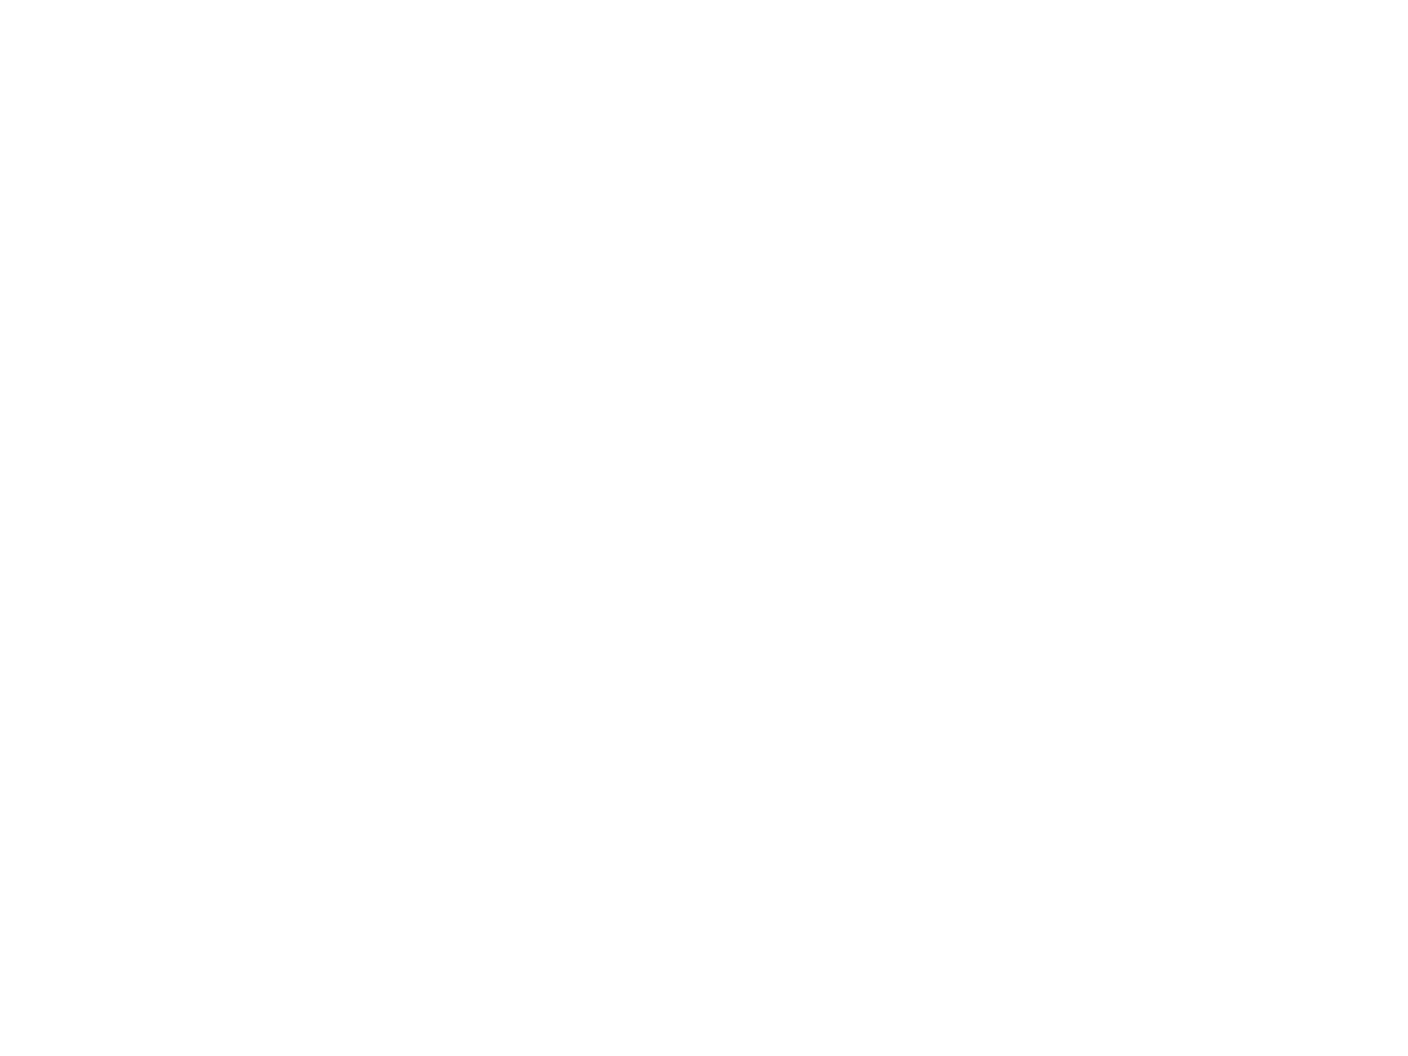

In [12]:
%matplotlib notebook
plotThis(glorot_tanh_loss, "glorot tanh loss")
plotThis(zero_tanh_loss, "zero tanh loss")
plotThis(normal_tanh_loss, "normal tanh loss")

plt.title("training loss")
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


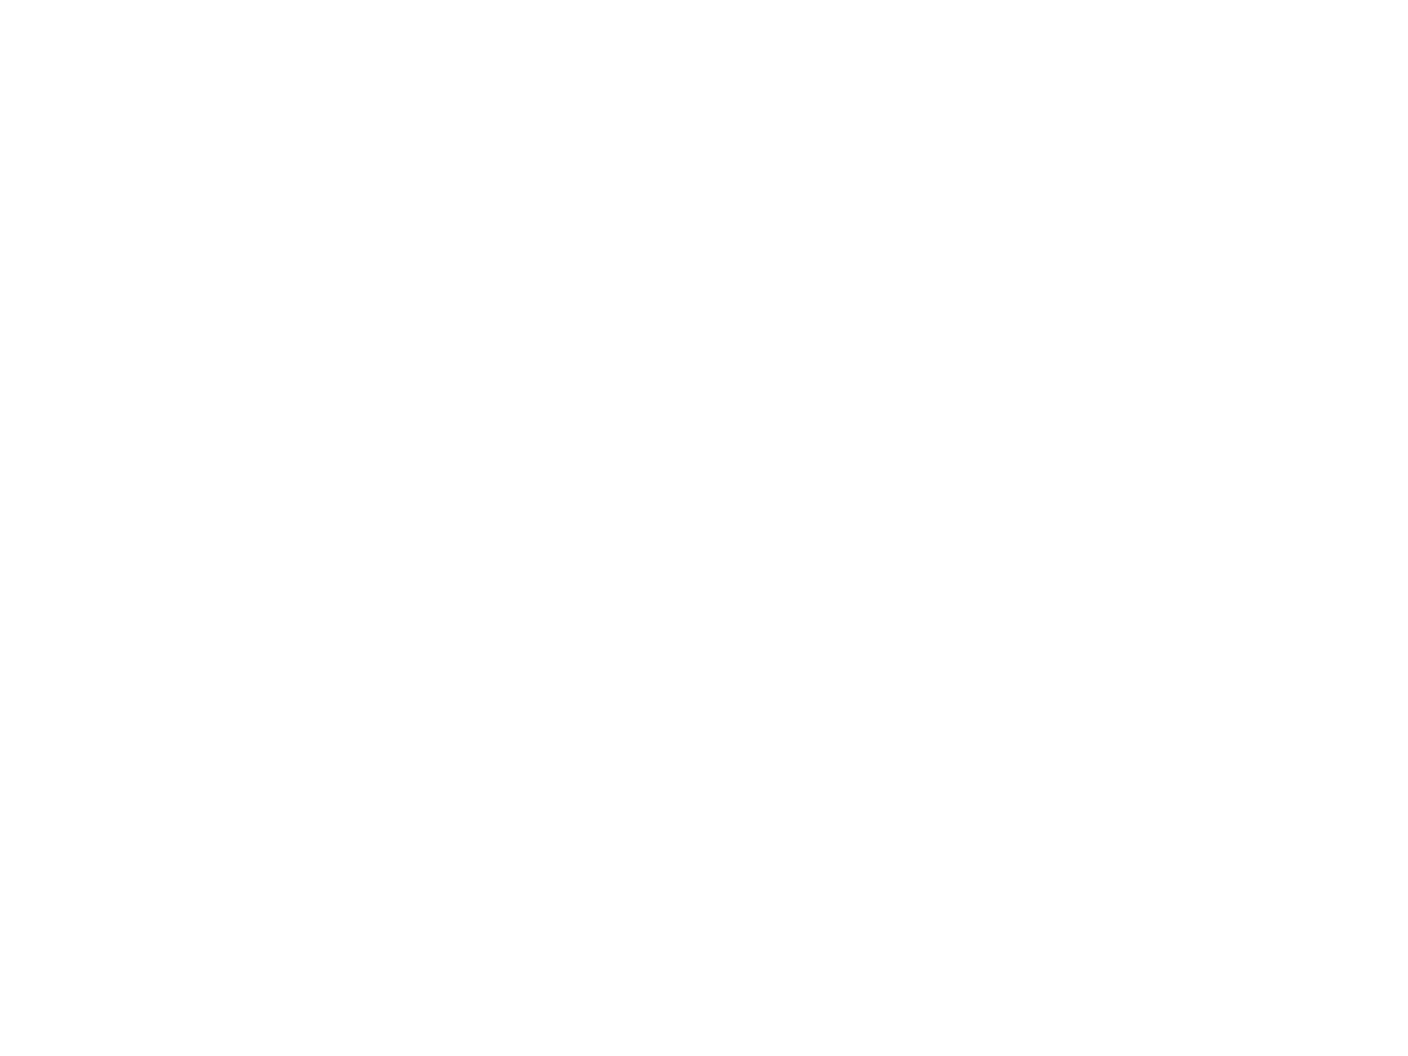

In [13]:
%matplotlib notebook
plotThis(glorot_tanh_accuracy, "glorot tanh accuracy")
plotThis(zero_tanh_accuracy, "zero tanh accuracy")
plotThis(normal_tanh_accuracy, "normal tanh accuracy")

plt.title("evaluation accuracy")
plt.legend()
plt.show()


In [14]:
myNet = NN([784,500,500,10], "sigmoid", lr=0.01, batch_size=32, initialization="glorot")
glorot_sigmoid_loss, glorot_sigmoid_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  3.1272959719023103
validation accuracy 63.32
loss  2.500506640195008
validation accuracy 76.12
loss  1.795104143821659
validation accuracy 82.72
loss  1.4242301560342328
validation accuracy 85.54
loss  1.2126097293040567
validation accuracy 87.11
loss  1.0830153913915566
validation accuracy 88.3
loss  0.9932132297622581
validation accuracy 88.88
loss  0.9263081180281072
validation accuracy 89.27
loss  0.8751121077906302
validation accuracy 89.61
loss  0.8350167503812511
validation accuracy 89.85


In [15]:
myNet = NN([784,500,500,10], "sigmoid", lr=0.01, batch_size=32, initialization="normal")
normal_sigmoid_loss, normal_sigmoid_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  5.160093091182784
validation accuracy 68.81
loss  2.5021005814585227
validation accuracy 77.19
loss  1.9380841306472267
validation accuracy 80.65
loss  1.645822766687719
validation accuracy 82.79
loss  1.4578776769537953
validation accuracy 84.29
loss  1.3226136054198212
validation accuracy 85.49
loss  1.2183833337993966
validation accuracy 86.11
loss  1.1341957256979216
validation accuracy 86.66
loss  1.0641255331891728
validation accuracy 87.27
loss  1.0045040274522319
validation accuracy 87.72


In [16]:
myNet = NN([784,500,500,10], "sigmoid", lr=0.01, batch_size=32, initialization="zero")
zero_sigmoid_loss, zero_sigmoid_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  3.2653398441139183
validation accuracy 9.91
loss  3.2591926700299307
validation accuracy 9.15
loss  3.2588772454782466
validation accuracy 9.15
loss  3.258573552342
validation accuracy 9.15
loss  3.2582811469420756
validation accuracy 10.3
loss  3.257999582744645
validation accuracy 10.3
loss  3.257728413689984
validation accuracy 10.3
loss  3.257467196836568
validation accuracy 10.3
loss  3.2572154942451856
validation accuracy 10.3
loss  3.2569728740441546
validation accuracy 10.3


<IPython.core.display.Javascript object>


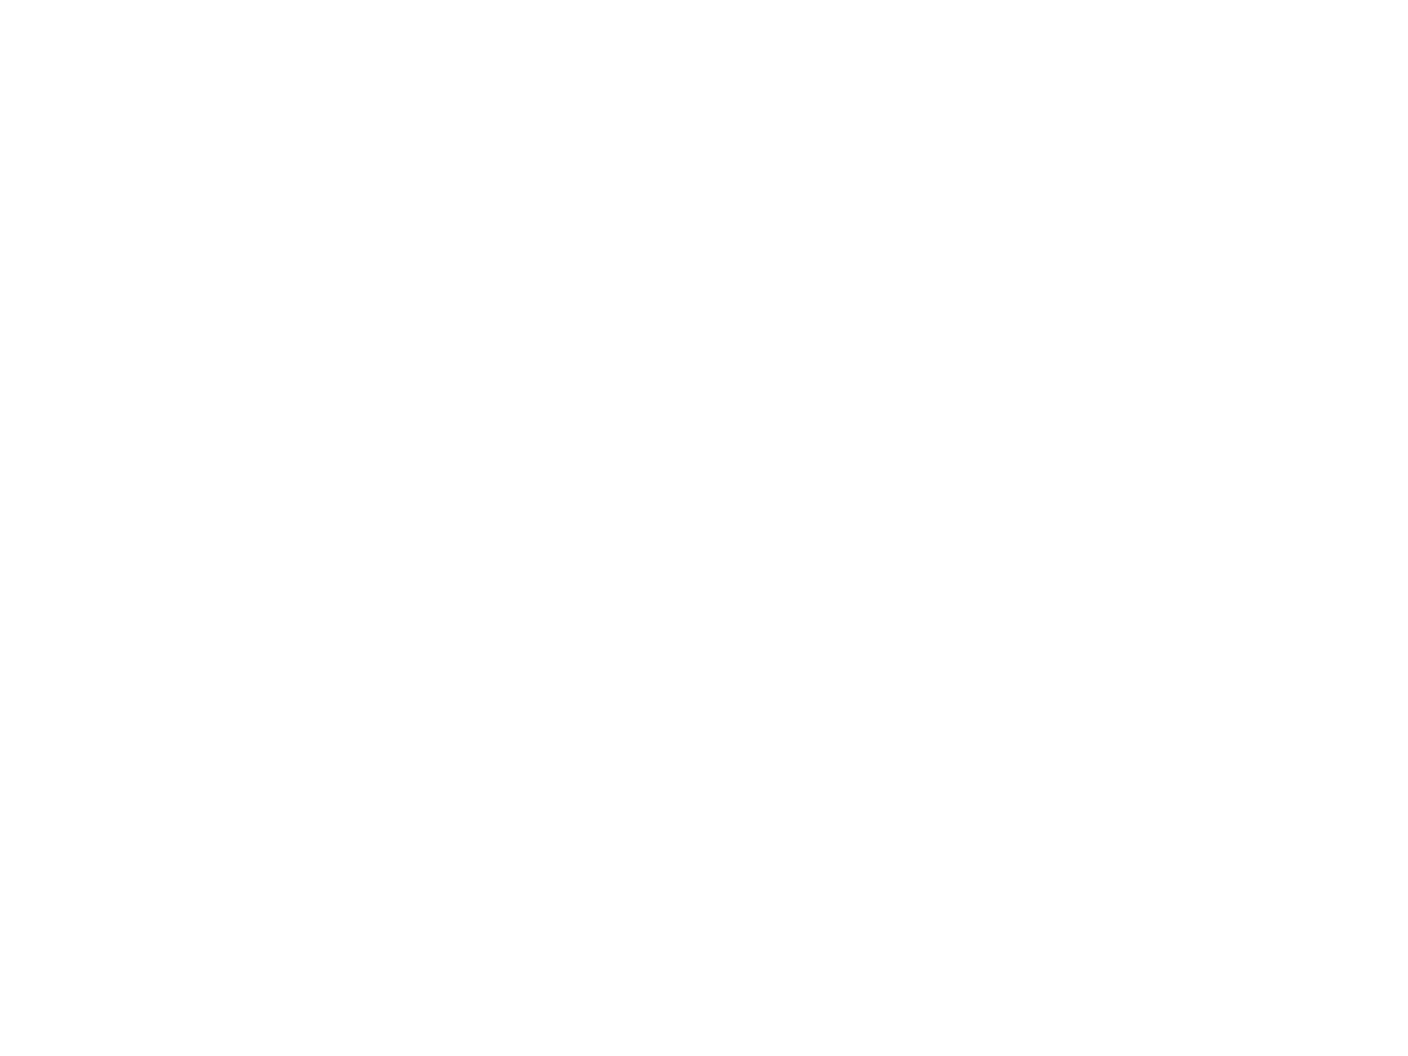

In [17]:
%matplotlib notebook
plotThis(glorot_sigmoid_loss, "glorot sigmoid loss")
plotThis(zero_sigmoid_loss, "zero sigmoid loss")
plotThis(normal_sigmoid_loss, "normal sigmoid loss")

plt.title("training loss")
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


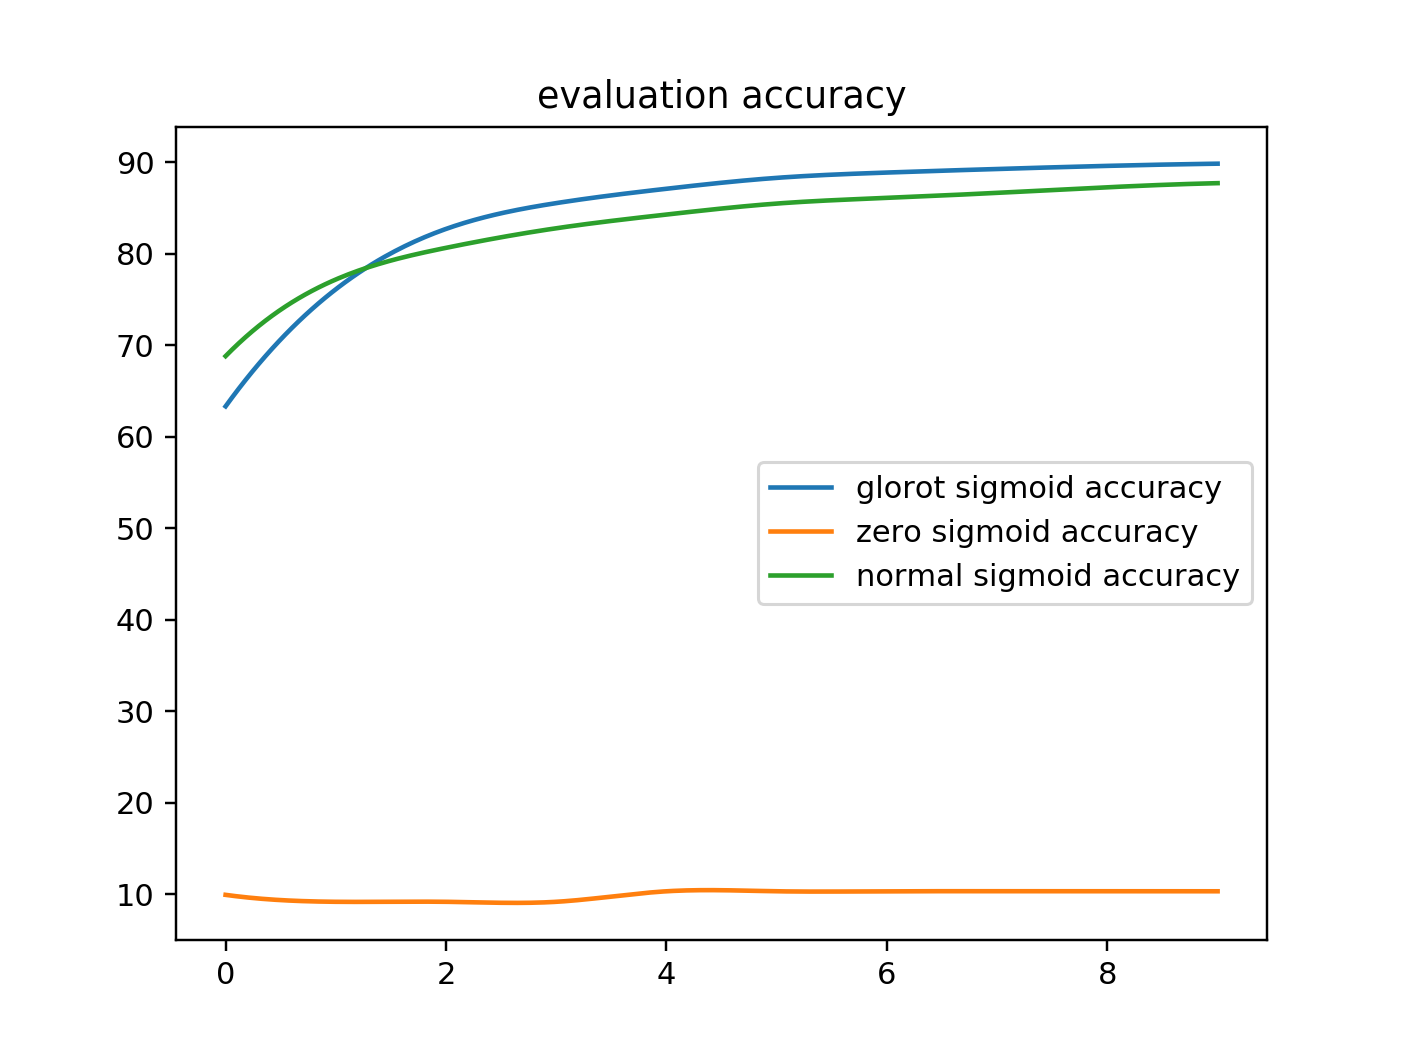

In [18]:
%matplotlib notebook
plotThis(glorot_sigmoid_accuracy, "glorot sigmoid accuracy")
plotThis(zero_sigmoid_accuracy, "zero sigmoid accuracy")
plotThis(normal_sigmoid_accuracy, "normal sigmoid accuracy")

plt.title("evaluation accuracy")
plt.legend()
plt.show()
